In [ ]:
import os
from os.path import exists
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.functional import log_softmax, pad
import math
import copy
import time
from torch.optim.lr_scheduler import LambdaLR
import pandas as pd
import altair as alt
from torchtext.data.functional import to_map_style_dataset
from torch.utils.data import DataLoader
from torchtext.vocab import build_vocab_from_iterator
import torchtext.datasets as datasets
import warnings

warnings.filterwarnings("ignore")
RUN_EXAMPLES = True

In [ ]:
# Some convenience helper functions used throughout the notebook
def show_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        return fn(*args)


def execute_example(fn, args=[]):
    if __name__ == "__main__" and RUN_EXAMPLES:
        fn(*args)


class DummyOptimizer(torch.optim.Optimizer):
    def __init__(self):
        self.param_groups = [{"lr": 0}]
        None

    def step(self):
        None

    def zero_grad(self, set_to_none=False):
        None


class DummyScheduler:
    def step(self):
        None

## Introduction to Self-Attention



We can think of self-attention as a mechanism that enhances the information content of an input embedding by including information about the input’s context. In other words, the self-attention mechanism enables the model to weigh the importance of different elements in an input sequence and dynamically adjust their influence on the output. 

Before we begin, let’s consider an input sentence “Life is short, eat dessert first” that we want to put through the self-attention mechanism. Similar to other types of modeling approaches **for** processing text (e.g., using recurrent neural networks or convolutional neural networks), we create a sentence embedding first.

For simplicity, here our dictionary dc is restricted to the words that occur in the input sentence. In a real-world application, we would consider all words in the training dataset (typical vocabulary sizes range between 30k to 50k).

In [ ]:
sentence = 'Life is short, eat dessert first'

dc = {s:i for i,s in enumerate(sorted(sentence.replace(',', '').split()))}
print(dc)

{'Life': 0, 'dessert': 1, 'eat': 2, 'first': 3, 'is': 4, 'short': 5}


Next, we use this dictionary to assign an integer index to each word:



In [ ]:
sentence_int = torch.tensor([dc[s] for s in sentence.replace(',', '').split()])
print(sentence_int)

tensor([0, 4, 5, 2, 1, 3])


Now, using the integer-vector representation of the input sentence, we can use an embedding layer to encode the inputs into a real-vector embedding. Here, we will use a 16-dimensional embedding such that each input word is represented by a 16-dimensional vector. Since the sentence consists of 6 words, this will result in a 6×16-dimensional embedding:

In [ ]:
torch.manual_seed(123)
embed = torch.nn.Embedding(6, 16)
embedded_sentence = embed(sentence_int).detach()

print(embedded_sentence)
print(embedded_sentence.shape)

tensor([[ 0.3374, -0.1778, -0.3035, -0.5880,  0.3486,  0.6603, -0.2196, -0.3792,
          0.7671, -1.1925,  0.6984, -1.4097,  0.1794,  1.8951,  0.4954,  0.2692],
        [ 0.5146,  0.9938, -0.2587, -1.0826, -0.0444,  1.6236, -2.3229,  1.0878,
          0.6716,  0.6933, -0.9487, -0.0765, -0.1526,  0.1167,  0.4403, -1.4465],
        [ 0.2553, -0.5496,  1.0042,  0.8272, -0.3948,  0.4892, -0.2168, -1.7472,
         -1.6025, -1.0764,  0.9031, -0.7218, -0.5951, -0.7112,  0.6230, -1.3729],
        [-1.3250,  0.1784, -2.1338,  1.0524, -0.3885, -0.9343, -0.4991, -1.0867,
          0.8805,  1.5542,  0.6266, -0.1755,  0.0983, -0.0935,  0.2662, -0.5850],
        [-0.0770, -1.0205, -0.1690,  0.9178,  1.5810,  1.3010,  1.2753, -0.2010,
          0.4965, -1.5723,  0.9666, -1.1481, -1.1589,  0.3255, -0.6315, -2.8400],
        [ 0.8768,  1.6221, -1.4779,  1.1331, -1.2203,  1.3139,  1.0533,  0.1388,
          2.2473, -0.8036, -0.2808,  0.7697, -0.6596, -0.7979,  0.1838,  0.2293]])
torch.Size([6, 16])


**Defining the Weight Matrices**

Now, let’s discuss the widely utilized self-attention mechanism known as the scaled dot-product attention, which is integrated into the transformer architecture. Self-attention utilizes three weight matrices, referred to as Wq, Wk, and Wv, which are adjusted as model parameters during training. These matrices serve to project the inputs into query, key, and value components of the sequence, respectively.

The respective query, key and value sequences are obtained via matrix multiplication between the weight matrices W and the embedded inputs x:

*   Query sequence: q(i)=Wqx(i) for i∈[1,T]
*   Key sequence: k(i)=Wkx(i) for i∈[1,T]
*   Value sequence: v(i)=Wvx(i) for i∈[1,T]

The index i  refers to the token index position in the input sequence, which has length T.

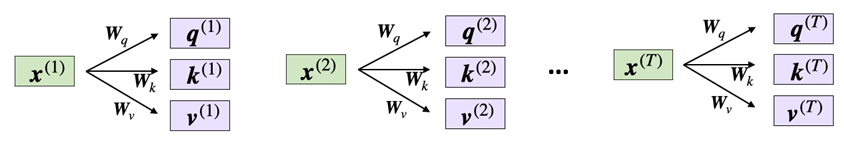


Here, both q(i)  and k(i)  are vectors of dimension dk . The projection matrices Wq  and Wk  have a shape of dk×d, while Wv has the shape dv×d. It’s important to note that d represents the size of each word vector, x.

Since we are computing the dot-product between the query and key vectors, these two vectors have to contain the same number of elements (dq=dk
). However, the number of elements in the value vector v(i)
, which determines the size of the resulting context vector, is arbitrary. So, for the following code walkthrough, we will set dq=dk=24
 and use dv=28, initializing the projection matrices as follows:



In [ ]:
torch.manual_seed(123)

d = embedded_sentence.shape[1]

d_q, d_k, d_v = 24, 24, 28

W_query = torch.rand(d_q, d)
W_key = torch.rand(d_k, d)
W_value = torch.rand(d_v, d)

**Computing the Unnormalized Attention Weights**

Now, let’s suppose we are interested in computing the attention-vector for the second input element – the second input element acts as the query here:


In [ ]:
x_2 = embedded_sentence[1]
query_2 = W_query.matmul(x_2)
key_2 = W_key.matmul(x_2)
value_2 = W_value.matmul(x_2)

print(query_2.shape)
print(key_2.shape)
print(value_2.shape)

torch.Size([24])
torch.Size([24])
torch.Size([28])


We can then generalize this to compute th remaining key, and value elements for all inputs as well, since we will need them in the next step when we compute the unnormalized attention weights ω:

In [ ]:
keys = W_key.matmul(embedded_sentence.T).T
values = W_value.matmul(embedded_sentence.T).T

print("keys.shape:", keys.shape)
print("values.shape:", values.shape)

keys.shape: torch.Size([6, 24])
values.shape: torch.Size([6, 28])


Now that we have all the required keys and values, we can proceed to the next step and compute the unnormalized attention weights ω, which are illustrated in the figure below:

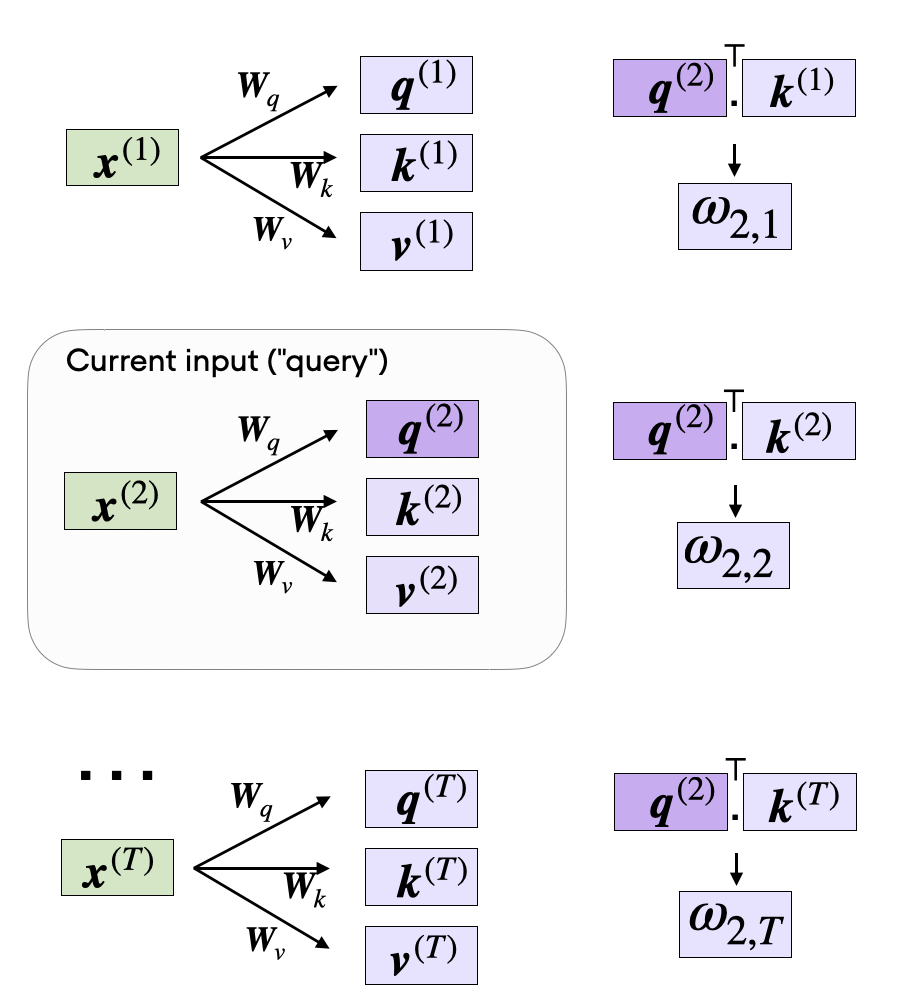

As illustrated in the figure above, we compute ωi,j
 as the dot product between the query and key sequences, ωij=q(i)⊤k(j).

In [ ]:
# We can compute the unnormalized attention weight for the query 
# and 5th input element (corresponding to index position 4) 
omega_24 = query_2.dot(keys[4])
print(omega_24)

tensor(11.1466)


Since we will need those to compute the attention scores later, let’s compute the ω values for all input tokens as illustrated in the previous figure:

In [ ]:
omega_2 = query_2.matmul(keys.T)
print(omega_2)

tensor([ 8.5808, -7.6597,  3.2558,  1.0395, 11.1466, -0.4800])


**Computing the Attention Scores**

The subsequent step in self-attention is to normalize the unnormalized attention weights, ω, to obtain the normalized attention weights, α
, by applying the softmax function. Additionally, 1/dk−−√ is used to scale ω
 before normalizing it through the softmax function, as shown below:

 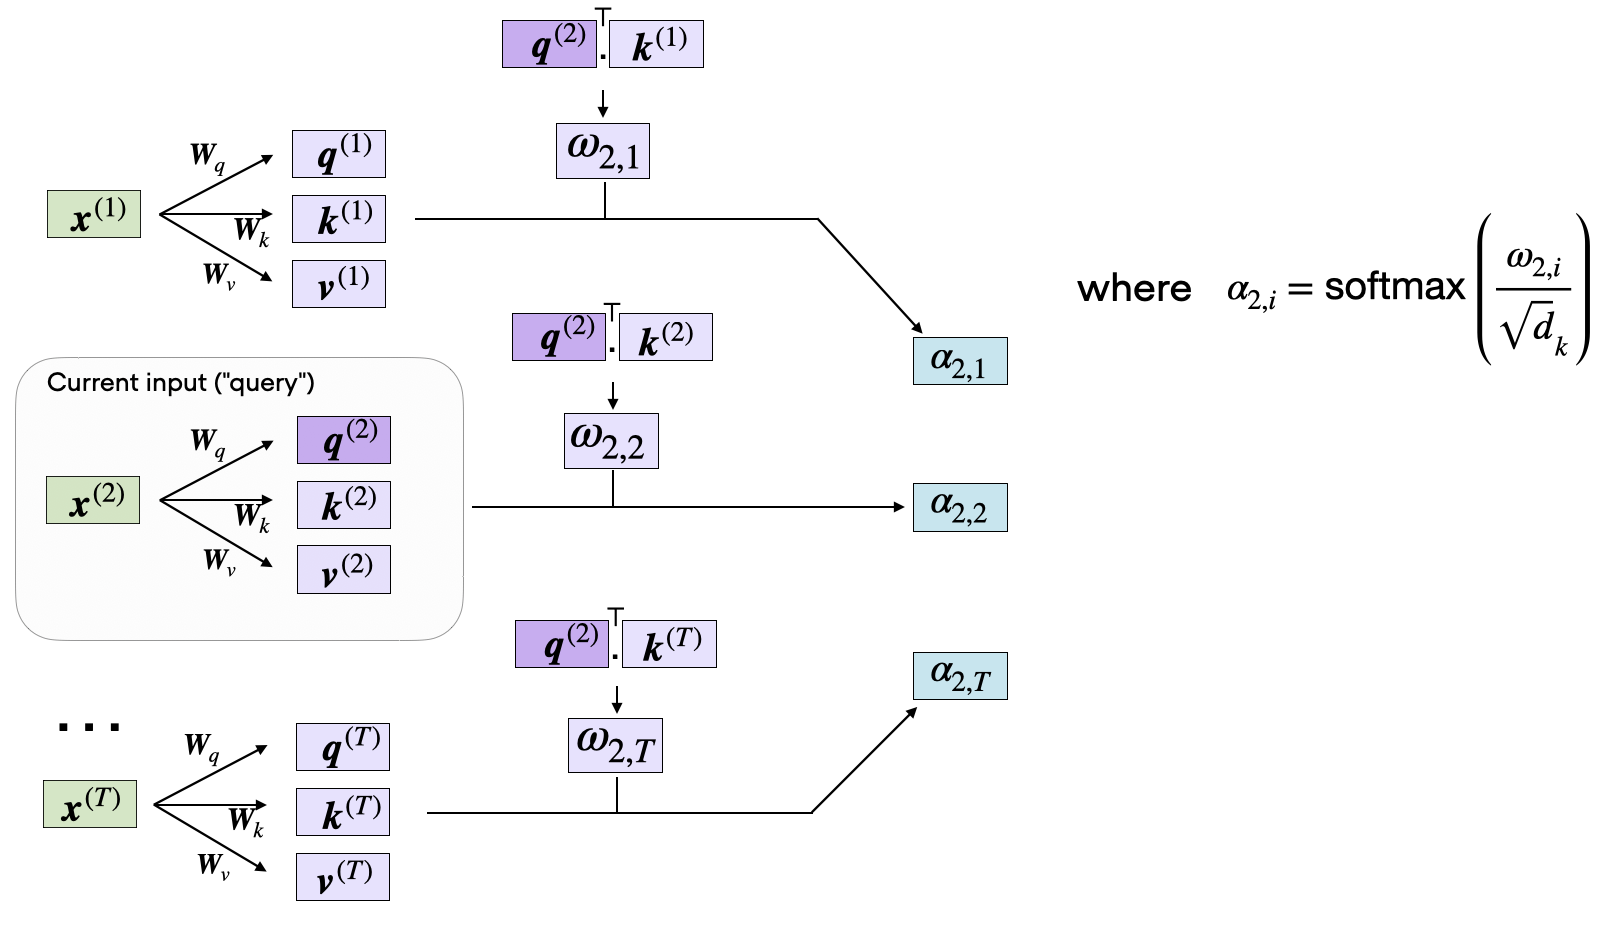

The scaling by dk ensures that the Euclidean length of the weight vectors will be approximately in the same magnitude. This helps prevent the attention weights from becoming too small or too large, which could lead to numerical instability or affect the model’s ability to converge during training.

In code, we can implement the computation of the attention weights as follows:

In [ ]:
attention_weights_2 = F.softmax(omega_2 / d_k**0.5, dim=0)
print(attention_weights_2)

tensor([0.2912, 0.0106, 0.0982, 0.0625, 0.4917, 0.0458])


Finally, the last step is to compute the context vector z(2)
, which is an attention-weighted version of our original query input x(2)
, including all the other input elements as its context via the attention weights:

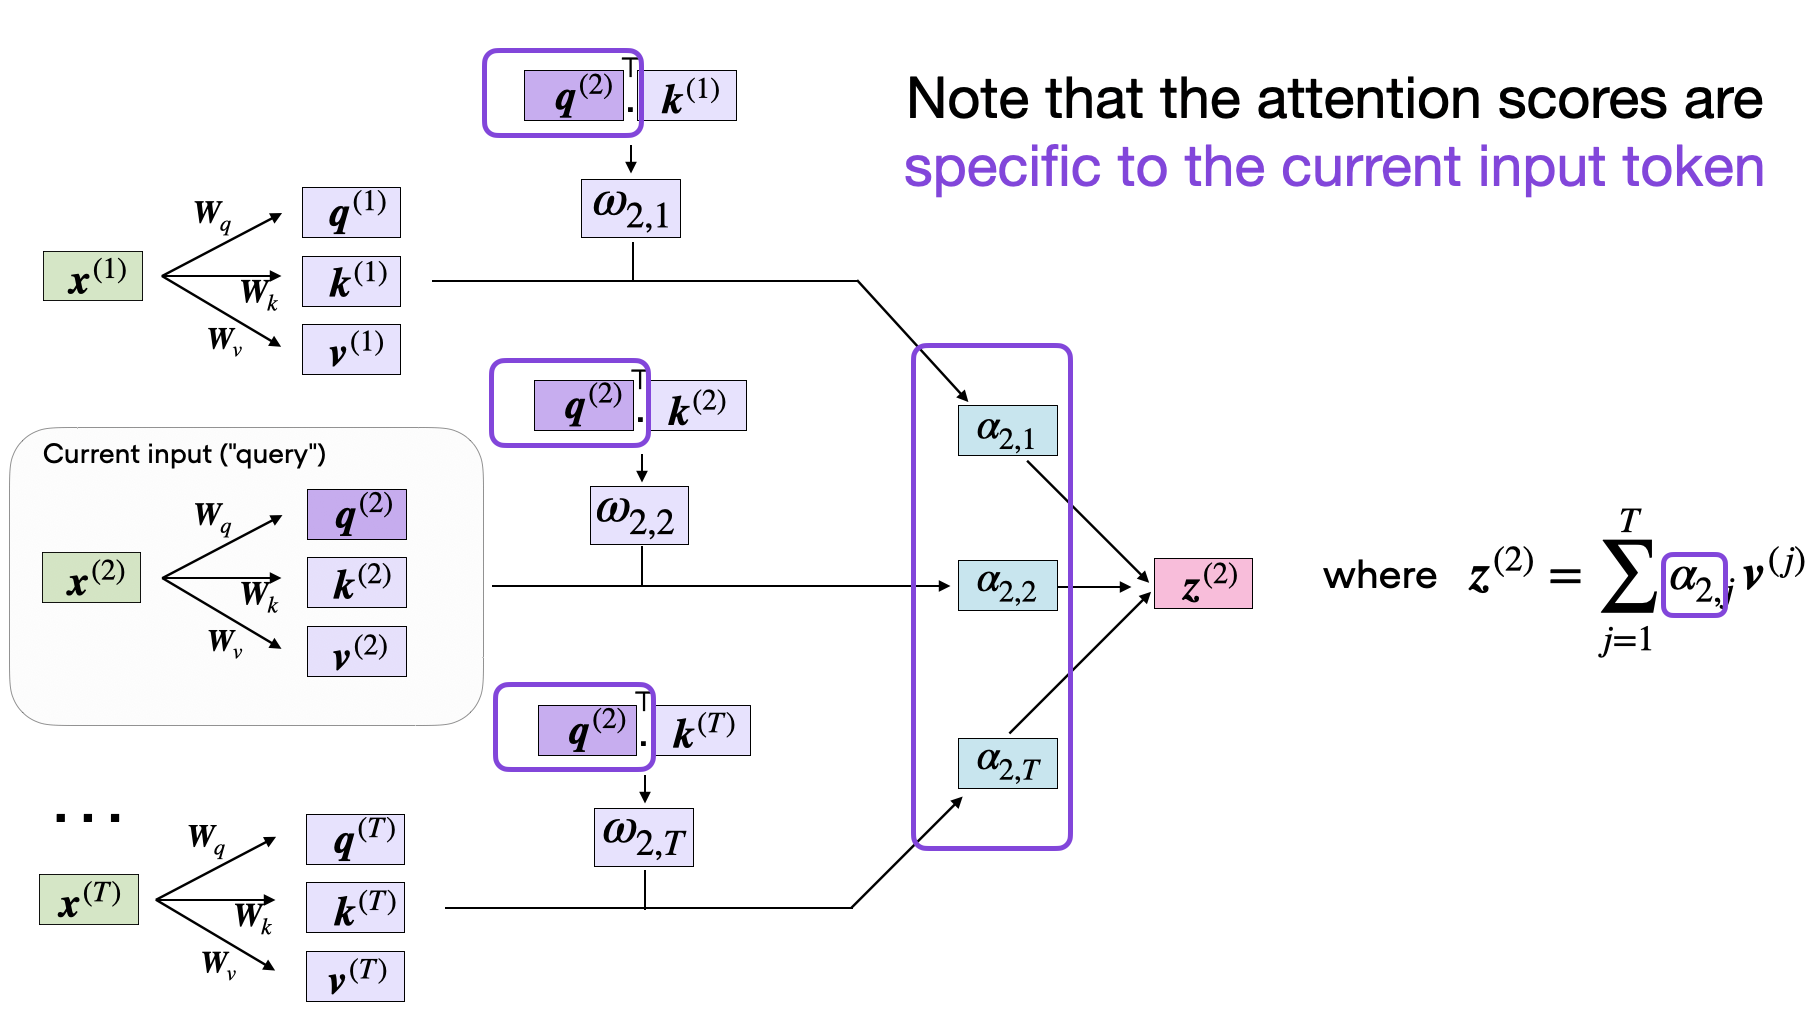

In code, this looks like as follows:

In [ ]:
context_vector_2 = attention_weights_2.matmul(values)

print(context_vector_2.shape)
print(context_vector_2)

torch.Size([28])
tensor([-1.5993,  0.0156,  1.2670,  0.0032, -0.6460, -1.1407, -0.4908, -1.4632,
         0.4747,  1.1926,  0.4506, -0.7110,  0.0602,  0.7125, -0.1628, -2.0184,
         0.3838, -2.1188, -0.8136, -1.5694,  0.7934, -0.2911, -1.3640, -0.2366,
        -0.9564, -0.5265,  0.0624,  1.7084])


Note that this output vector has more dimensions (dv=28
) than the original input vector (d=16
) since we specified dv>d
 earlier; however, the embedding size choice is arbitrary.

**Multi-Head Attention**

In the scaled dot-product attention, the input sequence was transformed using three matrices representing the query, key, and value. These three matrices can be considered as a single attention head in the context of multi-head attention. The figure below summarizes this single attention head we covered previously:
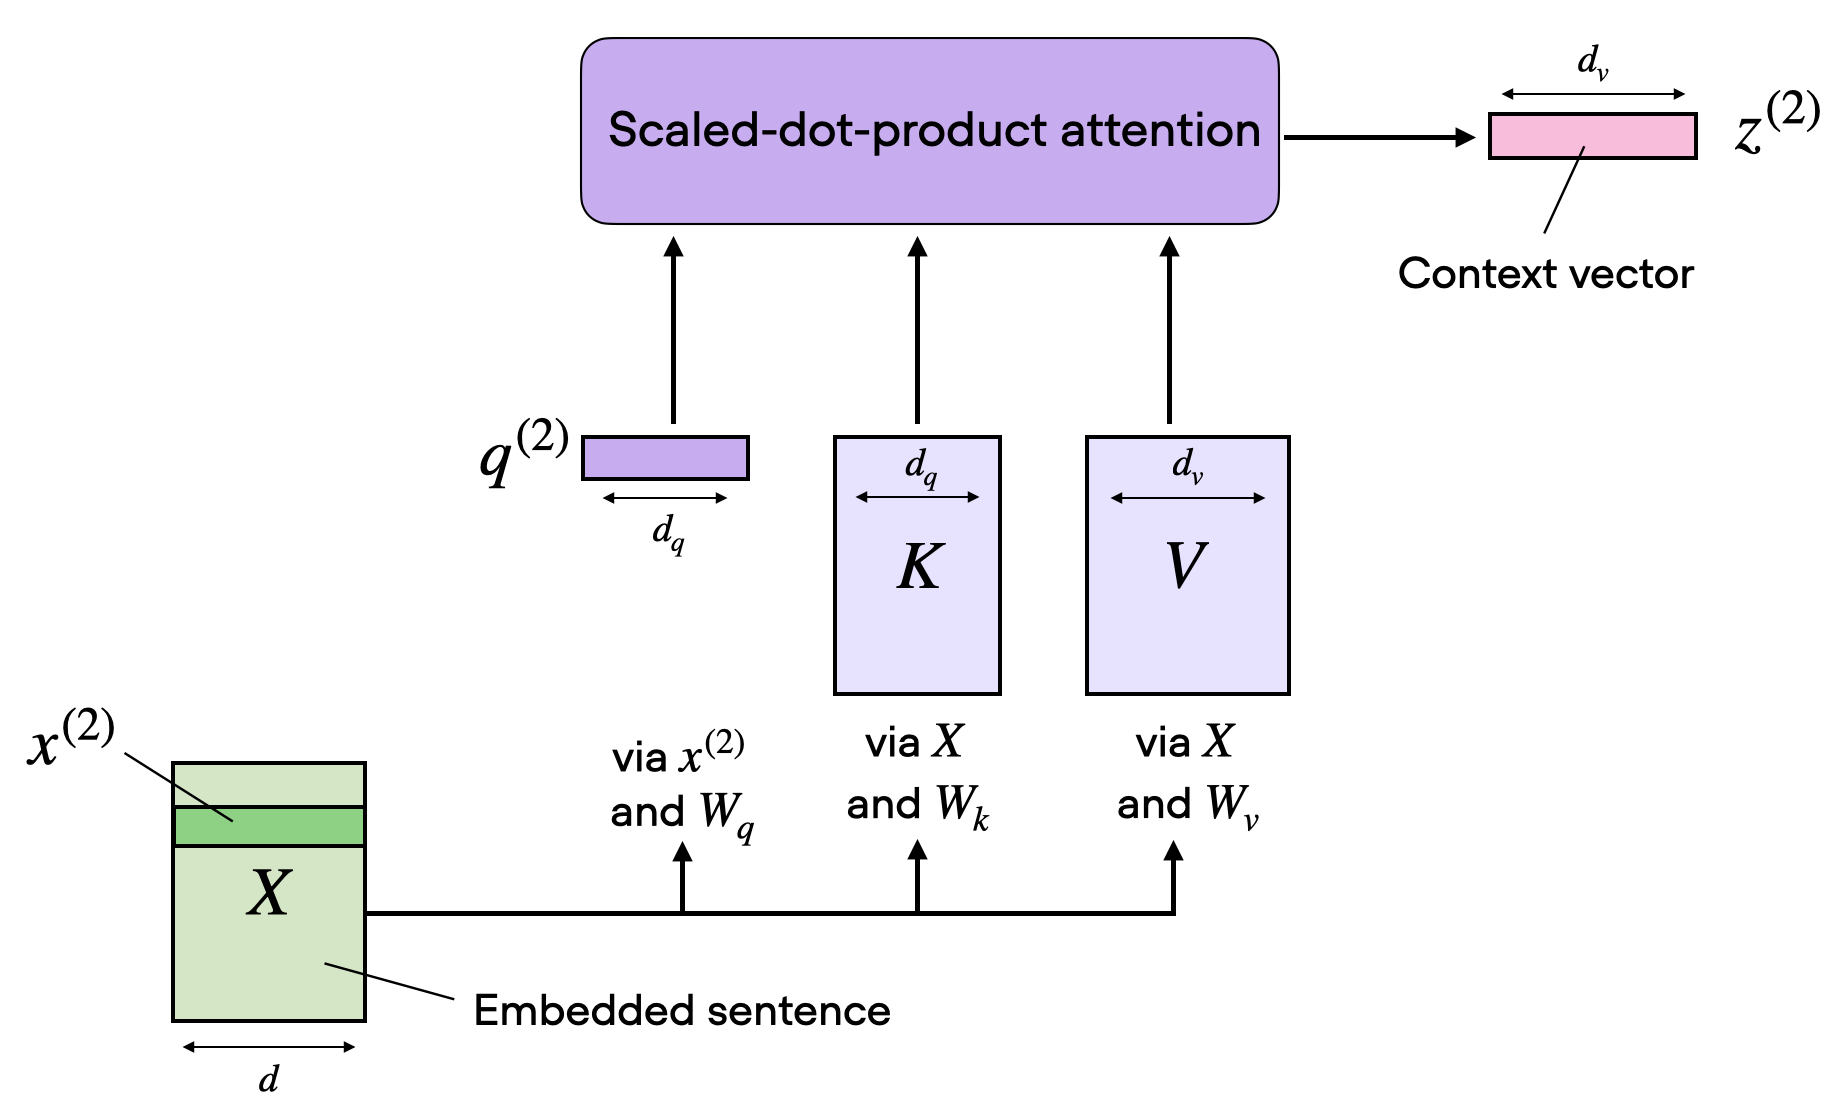

As its name implies, multi-head attention involves multiple such heads, each consisting of query, key, and value matrices. This concept is similar to the use of multiple kernels in convolutional neural networks.

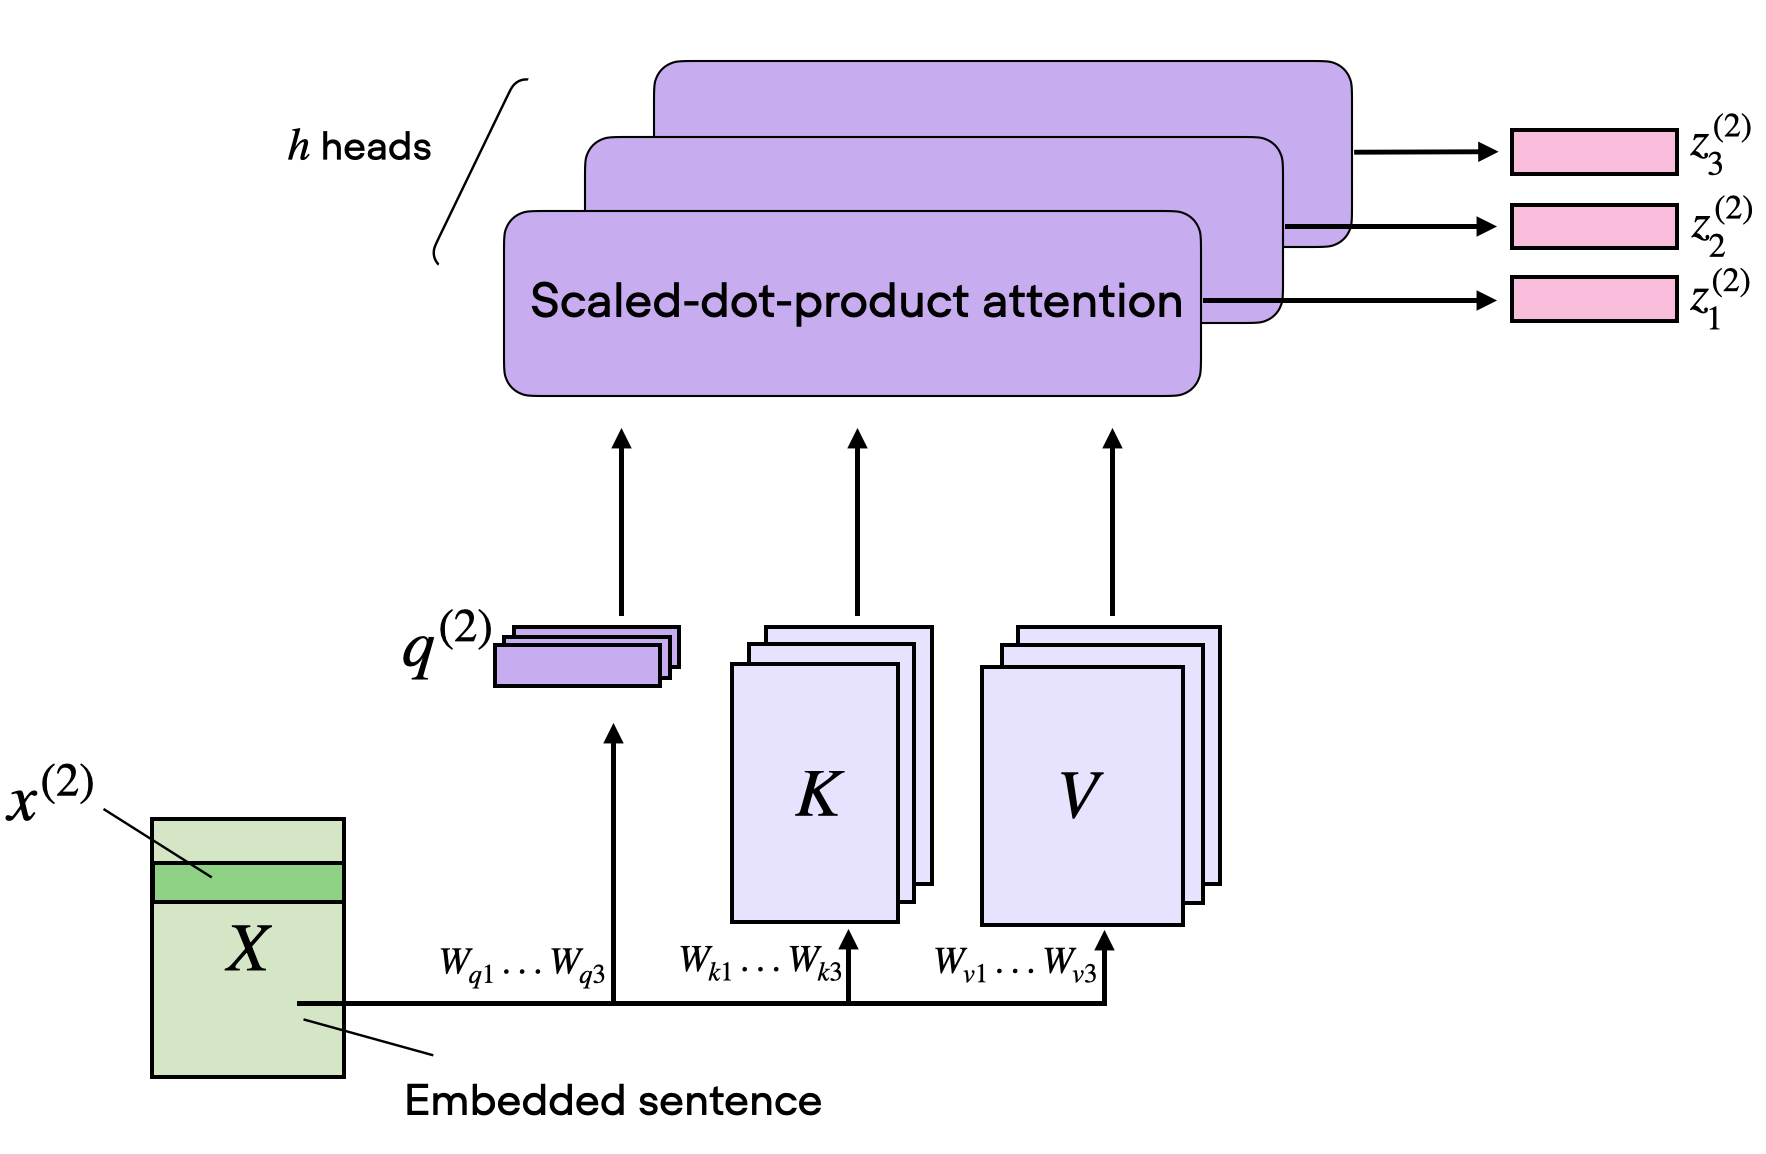

To illustrate this in code, suppose we have 3 attention heads, so we now extend the d′×d dimensional weight matrices so 3×d′×d:

In [ ]:
h = 3
multihead_W_query = torch.rand(h, d_q, d)
multihead_W_key = torch.rand(h, d_k, d)
multihead_W_value = torch.rand(h, d_v, d)

Consequently, each query element is now 3×dq
 dimensional, where dq=24
 (here, let’s keep the focus on the 3rd element corresponding to index position 2):

In [ ]:
multihead_query_2 = multihead_W_query.matmul(x_2)
print(multihead_query_2.shape)

torch.Size([3, 24])


We can then obtain the keys and values in a similar fashion:

In [ ]:
multihead_key_2 = multihead_W_key.matmul(x_2)
multihead_value_2 = multihead_W_value.matmul(x_2)

Now, these key and value elements are specific to the query element. But, similar to earlier, we will also need the value and keys for the other sequence elements in order to compute the attention scores for the query. We can do this is by expanding the input sequence embeddings to size 3, i.e., the number of attention heads:

In [ ]:
stacked_inputs = embedded_sentence.T.repeat(3, 1, 1)
print(stacked_inputs.shape)

torch.Size([3, 16, 6])


Now, we can compute compute all the keys and values using via torch.bmm() ( batch matrix multiplication):

In [ ]:
multihead_keys = torch.bmm(multihead_W_key, stacked_inputs)
multihead_values = torch.bmm(multihead_W_value, stacked_inputs)
print("multihead_keys.shape:", multihead_keys.shape)
print("multihead_values.shape:", multihead_values.shape)

multihead_keys.shape: torch.Size([3, 24, 6])
multihead_values.shape: torch.Size([3, 28, 6])


We now have tensors that represent the three attention heads in their first dimension. The third and second dimensions refer to the number of words and the embedding size, respectively. To make the values and keys more intuitive to interpret, we will swap the second and third dimensions, resulting in tensors with the same dimensional structure as the original input sequence, embedded_sentence:

In [ ]:
multihead_keys = multihead_keys.permute(0, 2, 1)
multihead_values = multihead_values.permute(0, 2, 1)
print("multihead_keys.shape:", multihead_keys.shape)
print("multihead_values.shape:", multihead_values.shape)

multihead_keys.shape: torch.Size([3, 6, 24])
multihead_values.shape: torch.Size([3, 6, 28])


Then, we follow the same steps as previously to compute the unscaled attention weights ω
 and attention weights α
, followed by the scaled-softmax computation to obtain an h×dv
 (here: 3×dv
) dimensional context vector z
 for the input element x(2)
.

**Cross-Attention**

In the code walkthrough above, we set dq=dk=24
 and dv=28
. Or in other words, we used the same dimensions for query and key sequences. While the value matrix Wv
 is often chosen to have the same dimension as the query and key matrices, we can select an arbitrary number size for the value dimensions.

Since the dimensions are sometimes a bit tricky to keep track of, let’s summarize everything we have covered so far in the figure below, which depicts the various tensor sizes for a single attention head.

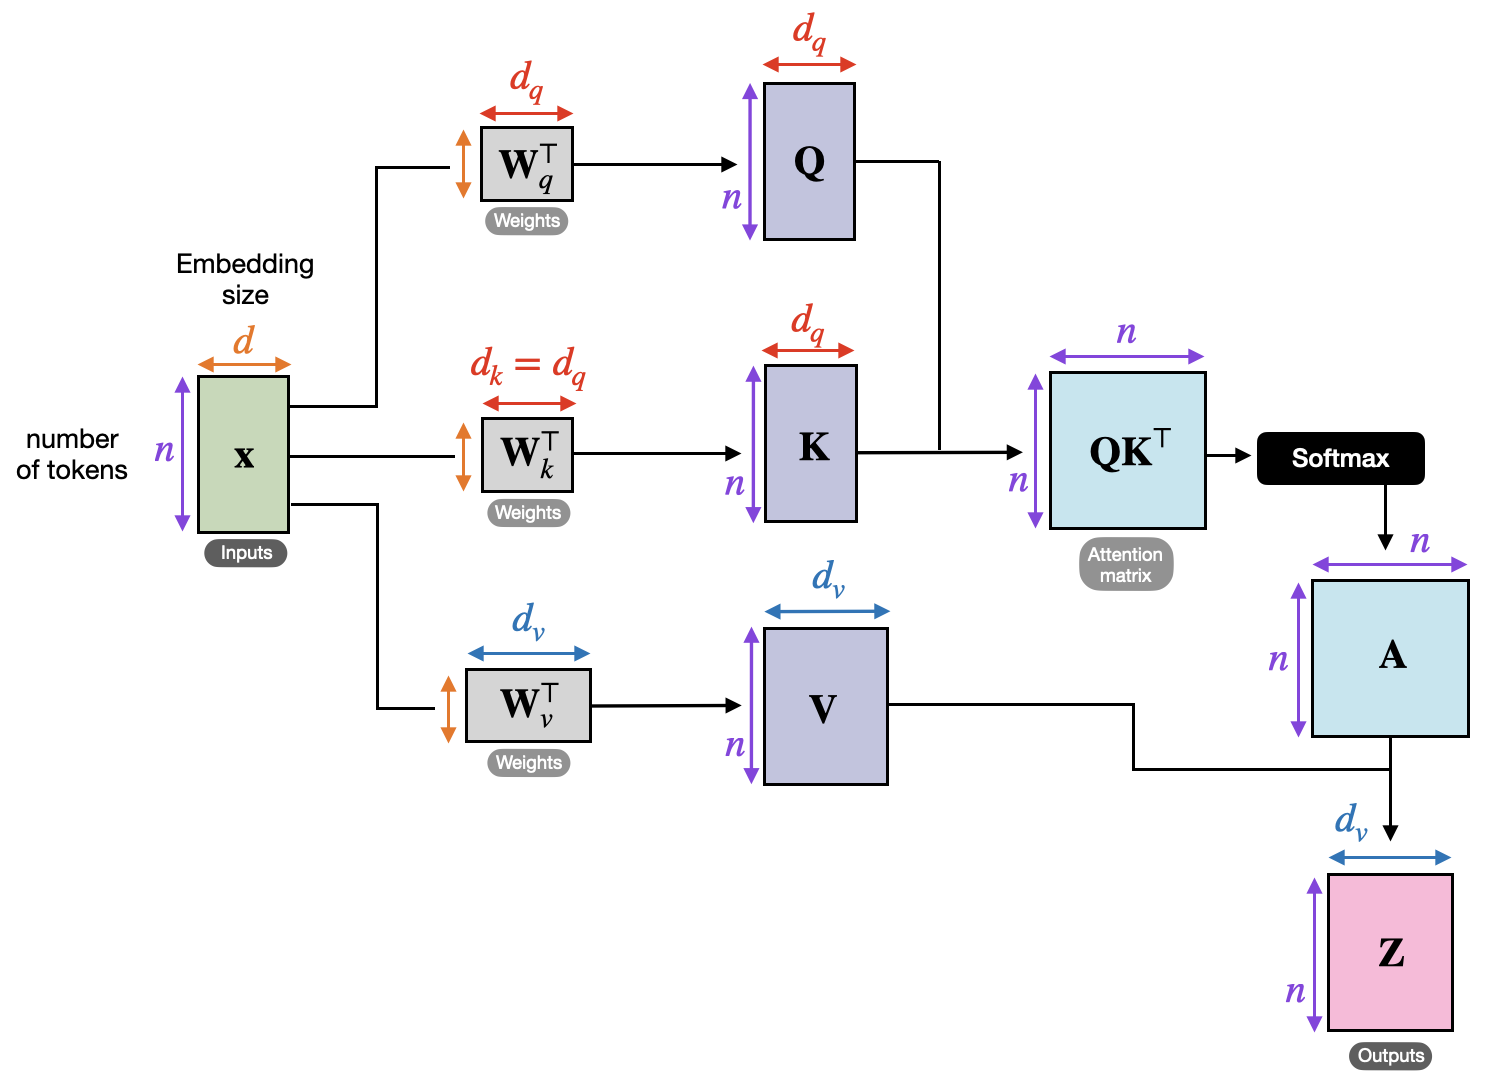

Now, the illustration above corresponds to the self-attention mechanism used in transformers. One particular flavor of this attention mechanism we have yet to discuss is cross-attention.

**What is cross-attention, and how does it differ from self-attention?**

In self-attention, we work with the same input sequence. In cross-attention, we mix or combine two different input sequences. In the case of the original transformer architecture above, that’s the sequence returned by the decoder module on the left and the input sequence being processed by the encoder part on the right.

Note that in cross-attention, the two input sequences x1
 and x2
 can have different numbers of elements. However, their embedding dimensions must match.

The figure below illustrates the concept of cross-attention. If we set x1=x2
, this is equivalent to self-attention.

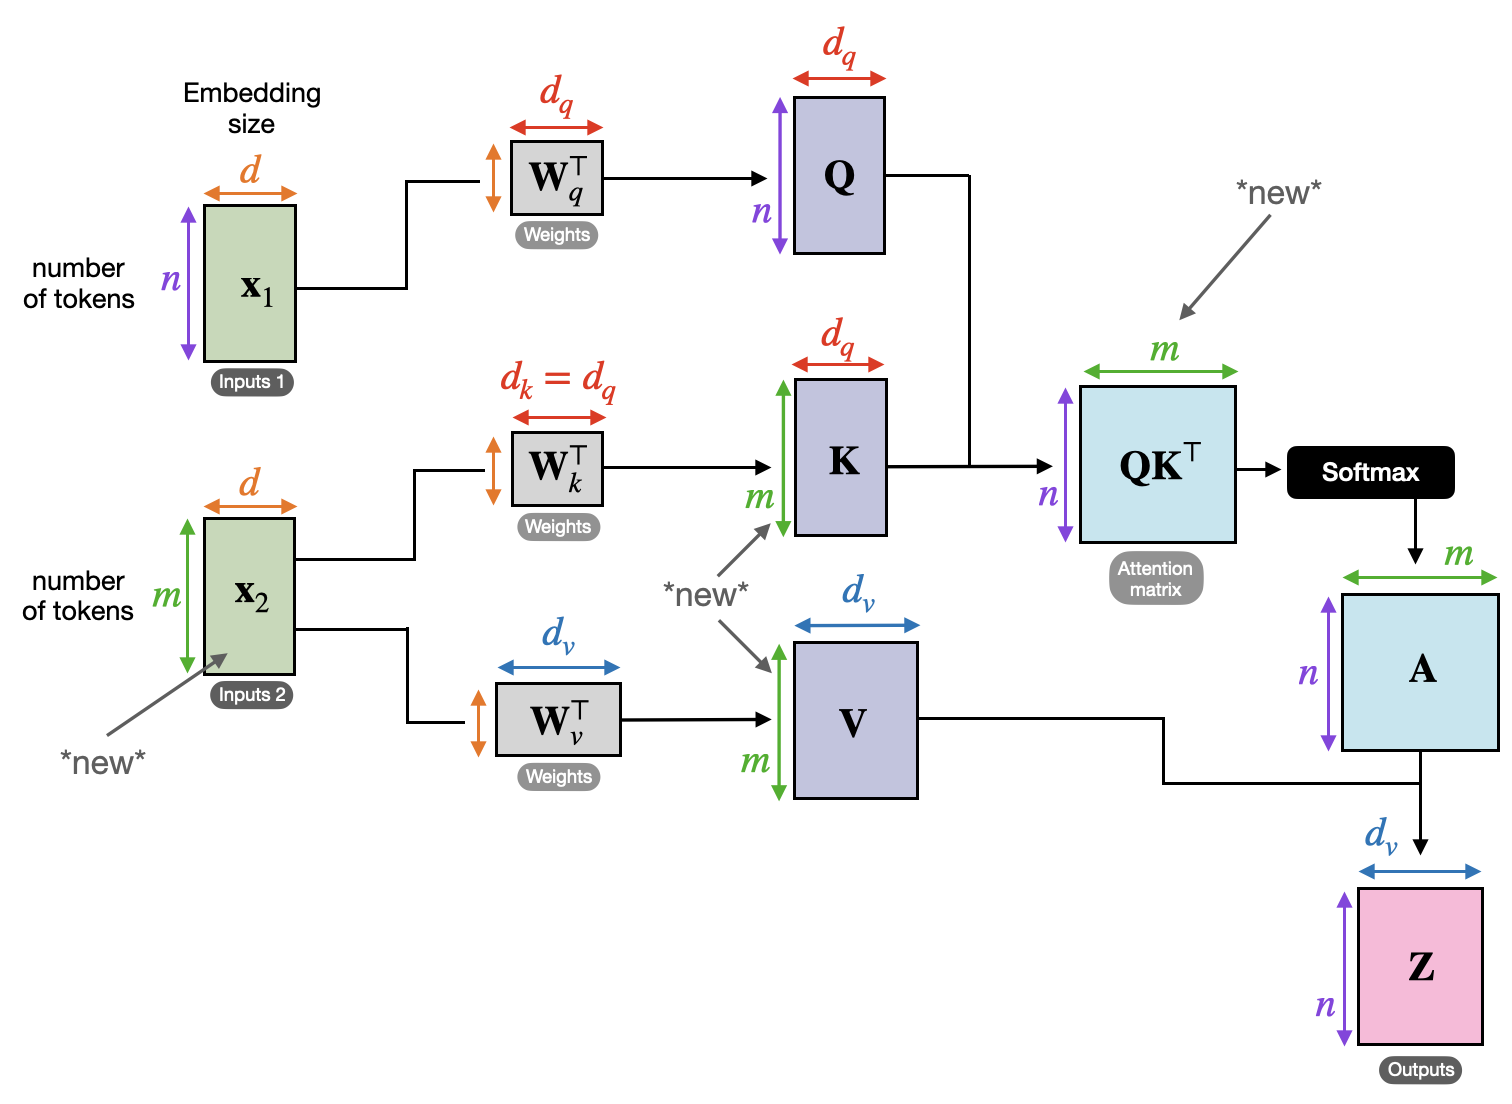

# Transformer model
Now we have all the elements to implement the Transformer model introduced in [Attention Is All You Need
](https://arxiv.org/pdf/1706.03762.pdf). 

# Model Architecture


Most competitive neural sequence transduction models have an
encoder-decoder structure
[(cite)](https://arxiv.org/abs/1409.0473). Here, the encoder maps an
input sequence of symbol representations $(x_1, ..., x_n)$ to a
sequence of continuous representations $\mathbf{z} = (z_1, ...,
z_n)$. Given $\mathbf{z}$, the decoder then generates an output
sequence $(y_1,...,y_m)$ of symbols one element at a time. At each
step the model is auto-regressive
[(cite)](https://arxiv.org/abs/1308.0850), consuming the previously
generated symbols as additional input when generating the next.

In [ ]:
class EncoderDecoder(nn.Module):
    """
    A standard Encoder-Decoder architecture. Base for this and many
    other models.
    """

    def __init__(self, encoder, decoder, src_embed, tgt_embed, generator):
        super(EncoderDecoder, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.src_embed = src_embed
        self.tgt_embed = tgt_embed
        self.generator = generator

    def forward(self, src, tgt, src_mask, tgt_mask):
        "Take in and process masked src and target sequences."
        return self.decode(self.encode(src, src_mask), src_mask, tgt, tgt_mask)

    def encode(self, src, src_mask):
        return self.encoder(self.src_embed(src), src_mask)

    def decode(self, memory, src_mask, tgt, tgt_mask):
        return self.decoder(self.tgt_embed(tgt), memory, src_mask, tgt_mask)

In [ ]:
class Generator(nn.Module):
    "Define standard linear + softmax generation step."

    def __init__(self, d_model, vocab):
        super(Generator, self).__init__()
        self.proj = nn.Linear(d_model, vocab)

    def forward(self, x):
        return log_softmax(self.proj(x), dim=-1)


The Transformer follows this overall architecture using stacked
self-attention and point-wise, fully connected layers for both the
encoder and decoder, shown in the left and right halves of the following figure,
respectively.

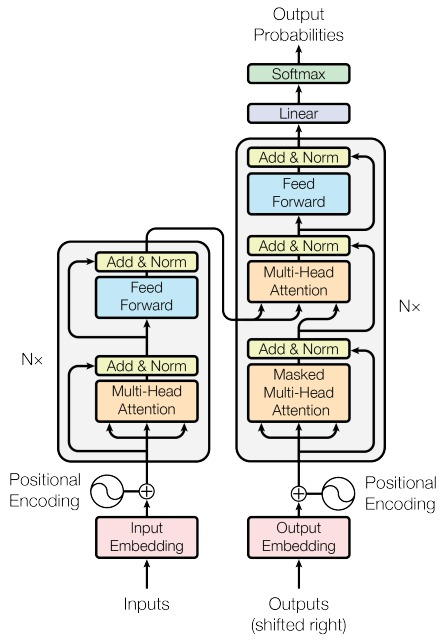

## Encoder and Decoder Stacks

### Encoder

The encoder is composed of a stack of $N=6$ identical layers.

In [ ]:
def clones(module, N):
    "Produce N identical layers."
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])

In [ ]:
class Encoder(nn.Module):
    "Core encoder is a stack of N layers"

    def __init__(self, layer, N):
        super(Encoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, mask):
        "Pass the input (and mask) through each layer in turn."
        for layer in self.layers:
            x = layer(x, mask)
        return self.norm(x)


We employ a residual connection
[(cite)](https://arxiv.org/abs/1512.03385) around each of the two
sub-layers, followed by layer normalization
[(cite)](https://arxiv.org/abs/1607.06450).

In [ ]:
class LayerNorm(nn.Module):
    "Construct a layernorm module (See citation for details)."

    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.a_2 = nn.Parameter(torch.ones(features))
        self.b_2 = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.a_2 * (x - mean) / (std + self.eps) + self.b_2


That is, the output of each sub-layer is $\mathrm{LayerNorm}(x +
\mathrm{Sublayer}(x))$, where $\mathrm{Sublayer}(x)$ is the function
implemented by the sub-layer itself.  We apply dropout
[(cite)](http://jmlr.org/papers/v15/srivastava14a.html) to the
output of each sub-layer, before it is added to the sub-layer input
and normalized.

To facilitate these residual connections, all sub-layers in the
model, as well as the embedding layers, produce outputs of dimension
$d_{\text{model}}=512$.

In [ ]:
class SublayerConnection(nn.Module):
    """
    A residual connection followed by a layer norm.
    Note for code simplicity the norm is first as opposed to last.
    """

    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        "Apply residual connection to any sublayer with the same size."
        return x + self.dropout(sublayer(self.norm(x)))


Each layer has two sub-layers. The first is a multi-head
self-attention mechanism, and the second is a simple, position-wise
fully connected feed-forward network.

In [ ]:
class EncoderLayer(nn.Module):
    "Encoder is made up of self-attn and feed forward (defined below)"

    def __init__(self, size, self_attn, feed_forward, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = self_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 2)
        self.size = size

    def forward(self, x, mask):
        "Follow Figure 1 (left) for connections."
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)

### Decoder

The decoder is also composed of a stack of $N=6$ identical layers.


In [ ]:
class Decoder(nn.Module):
    "Generic N layer decoder with masking."

    def __init__(self, layer, N):
        super(Decoder, self).__init__()
        self.layers = clones(layer, N)
        self.norm = LayerNorm(layer.size)

    def forward(self, x, memory, src_mask, tgt_mask):
        for layer in self.layers:
            x = layer(x, memory, src_mask, tgt_mask)
        return self.norm(x)


In addition to the two sub-layers in each encoder layer, the decoder
inserts a third sub-layer, which performs multi-head attention over
the output of the encoder stack.  Similar to the encoder, we employ
residual connections around each of the sub-layers, followed by
layer normalization.

In [ ]:
class DecoderLayer(nn.Module):
    "Decoder is made of self-attn, src-attn, and feed forward (defined below)"

    def __init__(self, size, self_attn, src_attn, feed_forward, dropout):
        super(DecoderLayer, self).__init__()
        self.size = size
        self.self_attn = self_attn
        self.src_attn = src_attn
        self.feed_forward = feed_forward
        self.sublayer = clones(SublayerConnection(size, dropout), 3)

    def forward(self, x, memory, src_mask, tgt_mask):
        "Follow Figure 1 (right) for connections."
        m = memory
        x = self.sublayer[0](x, lambda x: self.self_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.src_attn(x, m, m, src_mask))
        return self.sublayer[2](x, self.feed_forward)


We also modify the self-attention sub-layer in the decoder stack to
prevent positions from attending to subsequent positions.  This
masking, combined with fact that the output embeddings are offset by
one position, ensures that the predictions for position $i$ can
depend only on the known outputs at positions less than $i$.

In [ ]:
def subsequent_mask(size):
    "Mask out subsequent positions."
    attn_shape = (1, size, size)
    subsequent_mask = torch.triu(torch.ones(attn_shape), diagonal=1).type(
        torch.uint8
    )
    return subsequent_mask == 0


> Below the attention mask shows the position each tgt word (row) is
> allowed to look at (column). Words are blocked for attending to
> future words during training.

In [ ]:
def example_mask():
    LS_data = pd.concat(
        [
            pd.DataFrame(
                {
                    "Subsequent Mask": subsequent_mask(20)[0][x, y].flatten(),
                    "Window": y,
                    "Masking": x,
                }
            )
            for y in range(20)
            for x in range(20)
        ]
    )

    return (
        alt.Chart(LS_data)
        .mark_rect()
        .properties(height=250, width=250)
        .encode(
            alt.X("Window:O"),
            alt.Y("Masking:O"),
            alt.Color("Subsequent Mask:Q", scale=alt.Scale(scheme="viridis")),
        )
        .interactive()
    )


show_example(example_mask)

alt.Chart(...)


In practice, we compute the attention function on a set of queries
simultaneously, packed together into a matrix $Q$.  The keys and
values are also packed together into matrices $K$ and $V$.  We
compute the matrix of outputs as:

$$
   \mathrm{Attention}(Q, K, V) = \mathrm{softmax}(\frac{QK^T}{\sqrt{d_k}})V
$$

In [ ]:
def attention(query, key, value, mask=None, dropout=None):
    "Compute 'Scaled Dot Product Attention'"
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
    if mask is not None:
        scores = scores.masked_fill(mask == 0, -1e9)
    p_attn = scores.softmax(dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value), p_attn


Multi-head attention allows the model to jointly attend to
information from different representation subspaces at different
positions. With a single attention head, averaging inhibits this.

$$
\mathrm{MultiHead}(Q, K, V) =
    \mathrm{Concat}(\mathrm{head_1}, ..., \mathrm{head_h})W^O \\
    \text{where}~\mathrm{head_i} = \mathrm{Attention}(QW^Q_i, KW^K_i, VW^V_i)
$$

Where the projections are parameter matrices $W^Q_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^K_i \in
\mathbb{R}^{d_{\text{model}} \times d_k}$, $W^V_i \in
\mathbb{R}^{d_{\text{model}} \times d_v}$ and $W^O \in
\mathbb{R}^{hd_v \times d_{\text{model}}}$.

In this work we employ $h=8$ parallel attention layers, or
heads. For each of these we use $d_k=d_v=d_{\text{model}}/h=64$. Due
to the reduced dimension of each head, the total computational cost
is similar to that of single-head attention with full
dimensionality.

In [ ]:
class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        "Take in model size and number of heads."
        super(MultiHeadedAttention, self).__init__()
        assert d_model % h == 0
        # We assume d_v always equals d_k
        self.d_k = d_model // h
        self.h = h
        self.linears = clones(nn.Linear(d_model, d_model), 4)
        self.attn = None
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        "Implements Figure 2"
        if mask is not None:
            # Same mask applied to all h heads.
            mask = mask.unsqueeze(1)
        nbatches = query.size(0)

        # 1) Do all the linear projections in batch from d_model => h x d_k
        query, key, value = [
            lin(x).view(nbatches, -1, self.h, self.d_k).transpose(1, 2)
            for lin, x in zip(self.linears, (query, key, value))
        ]

        # 2) Apply attention on all the projected vectors in batch.
        x, self.attn = attention(
            query, key, value, mask=mask, dropout=self.dropout
        )

        # 3) "Concat" using a view and apply a final linear.
        x = (
            x.transpose(1, 2)
            .contiguous()
            .view(nbatches, -1, self.h * self.d_k)
        )
        del query
        del key
        del value
        return self.linears[-1](x)

## Position-wise Feed-Forward Networks

In addition to attention sub-layers, each of the layers in our
encoder and decoder contains a fully connected feed-forward network,
which is applied to each position separately and identically.  This
consists of two linear transformations with a ReLU activation in
between.

$$\mathrm{FFN}(x)=\max(0, xW_1 + b_1) W_2 + b_2$$

While the linear transformations are the same across different
positions, they use different parameters from layer to
layer. Another way of describing this is as two convolutions with
kernel size 1.  The dimensionality of input and output is
$d_{\text{model}}=512$, and the inner-layer has dimensionality
$d_{ff}=2048$.

In [ ]:
class PositionwiseFeedForward(nn.Module):
    "Implements FFN equation."

    def __init__(self, d_model, d_ff, dropout=0.1):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        return self.w_2(self.dropout(self.w_1(x).relu()))

## Embeddings and Softmax

Similarly to other sequence transduction models, we use learned
embeddings to convert the input tokens and output tokens to vectors
of dimension $d_{\text{model}}$.  We also use the usual learned
linear transformation and softmax function to convert the decoder
output to predicted next-token probabilities.  In our model, we
share the same weight matrix between the two embedding layers and
the pre-softmax linear transformation, similar to
[(cite)](https://arxiv.org/abs/1608.05859). In the embedding layers,
we multiply those weights by $\sqrt{d_{\text{model}}}$.

In [ ]:
class Embeddings(nn.Module):
    def __init__(self, d_model, vocab):
        super(Embeddings, self).__init__()
        self.lut = nn.Embedding(vocab, d_model)
        self.d_model = d_model

    def forward(self, x):
        return self.lut(x) * math.sqrt(self.d_model)

## Positional Encoding

Since our model contains no recurrence and no convolution, in order
for the model to make use of the order of the sequence, we must
inject some information about the relative or absolute position of
the tokens in the sequence.  To this end, we add "positional
encodings" to the input embeddings at the bottoms of the encoder and
decoder stacks.  The positional encodings have the same dimension
$d_{\text{model}}$ as the embeddings, so that the two can be summed.
There are many choices of positional encodings, learned and fixed
[(cite)](https://arxiv.org/pdf/1705.03122.pdf).

In this work, we use sine and cosine functions of different frequencies:

$$PE_{(pos,2i)} = \sin(pos / 10000^{2i/d_{\text{model}}})$$

$$PE_{(pos,2i+1)} = \cos(pos / 10000^{2i/d_{\text{model}}})$$

where $pos$ is the position and $i$ is the dimension.  That is, each
dimension of the positional encoding corresponds to a sinusoid.  The
wavelengths form a geometric progression from $2\pi$ to $10000 \cdot
2\pi$.  We chose this function because we hypothesized it would
allow the model to easily learn to attend by relative positions,
since for any fixed offset $k$, $PE_{pos+k}$ can be represented as a
linear function of $PE_{pos}$.

In addition, we apply dropout to the sums of the embeddings and the
positional encodings in both the encoder and decoder stacks.  For
the base model, we use a rate of $P_{drop}=0.1$.



In [ ]:
class PositionalEncoding(nn.Module):
    "Implement the PE function."

    def __init__(self, d_model, dropout, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Compute the positional encodings once in log space.
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer("pe", pe)

    def forward(self, x):
        x = x + self.pe[:, : x.size(1)].requires_grad_(False)
        return self.dropout(x)

## Full Model

> Here we define a function from hyperparameters to a full model.

In [ ]:
def make_model(
    src_vocab, tgt_vocab, N=6, d_model=512, d_ff=2048, h=8, dropout=0.1
):
    "Helper: Construct a model from hyperparameters."
    c = copy.deepcopy
    attn = MultiHeadedAttention(h, d_model)
    ff = PositionwiseFeedForward(d_model, d_ff, dropout)
    position = PositionalEncoding(d_model, dropout)
    model = EncoderDecoder(
        Encoder(EncoderLayer(d_model, c(attn), c(ff), dropout), N),
        Decoder(DecoderLayer(d_model, c(attn), c(attn), c(ff), dropout), N),
        nn.Sequential(Embeddings(d_model, src_vocab), c(position)),
        nn.Sequential(Embeddings(d_model, tgt_vocab), c(position)),
        Generator(d_model, tgt_vocab),
    )


    # Initialize parameters.
    for p in model.parameters():
        if p.dim() > 1:
            nn.init.xavier_uniform_(p)
    return model

## Inference:

> Here we make a forward step to generate a prediction of the
model. We try to use our transformer to memorize the input. As you
will see the output is randomly generated due to the fact that the
model is not trained yet. In the next part we will build the
training function and try to train our model to memorize the numbers
from 1 to 10.

In [ ]:
def inference_test():
    test_model = make_model(11, 11, 2)
    test_model.eval()
    src = torch.LongTensor([[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]])
    src_mask = torch.ones(1, 1, 10)

    memory = test_model.encode(src, src_mask)
    ys = torch.zeros(1, 1).type_as(src)

    for i in range(9):
        out = test_model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = test_model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.empty(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )

    print("Example Untrained Model Prediction:", ys)


def run_tests():
    for _ in range(10):
        inference_test()


show_example(run_tests)

Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])
Example Untrained Model Prediction: tensor([[0, 9, 1, 8, 9, 1, 9, 9, 9, 9]])
Example Untrained Model Prediction: tensor([[0, 5, 9, 9, 9, 9, 9, 9, 9, 9]])
Example Untrained Model Prediction: tensor([[0, 2, 2, 2, 2, 2, 2, 2, 2, 2]])
Example Untrained Model Prediction: tensor([[ 0,  4, 10,  1,  8, 10,  1,  8, 10,  1]])
Example Untrained Model Prediction: tensor([[0, 7, 5, 2, 0, 7, 5, 9, 0, 7]])
Example Untrained Model Prediction: tensor([[0, 3, 1, 1, 1, 1, 1, 1, 1, 1]])
Example Untrained Model Prediction: tensor([[0, 2, 5, 6, 2, 5, 6, 9, 1, 1]])
Example Untrained Model Prediction: tensor([[ 0, 10,  6,  5,  7,  7,  7,  7,  7,  7]])
Example Untrained Model Prediction: tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])


# Training



## Batches and Masking

In [ ]:
class Batch:
    """Object for holding a batch of data with mask during training."""

    def __init__(self, src, tgt=None, pad=2):  # 2 = <blank>
        self.src = src
        self.src_mask = (src != pad).unsqueeze(-2)
        if tgt is not None:
            self.tgt = tgt[:, :-1]
            self.tgt_y = tgt[:, 1:]
            self.tgt_mask = self.make_std_mask(self.tgt, pad)
            self.ntokens = (self.tgt_y != pad).data.sum()

    @staticmethod
    def make_std_mask(tgt, pad):
        "Create a mask to hide padding and future words."
        tgt_mask = (tgt != pad).unsqueeze(-2)
        tgt_mask = tgt_mask & subsequent_mask(tgt.size(-1)).type_as(
            tgt_mask.data
        )
        return tgt_mask


> Next we create a generic training and scoring function to keep
> track of the loss. We pass in a generic loss compute function that
> also handles parameter updates.

## Training Loop

In [ ]:
class TrainState:
    """Track number of steps, examples, and tokens processed"""

    step: int = 0  # Steps in the current epoch
    accum_step: int = 0  # Number of gradient accumulation steps
    samples: int = 0  # total # of examples used
    tokens: int = 0  # total # of tokens processed

In [ ]:
def run_epoch(
    data_iter,
    model,
    loss_compute,
    optimizer,
    scheduler,
    mode="train",
    accum_iter=1,
    train_state=TrainState(),
):
    """Train a single epoch"""
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    n_accum = 0
    device = torch.device("cuda")

    for i, batch in enumerate(data_iter):
        batch.src, batch.tgt, batch.tgt_y, batch.src_mask, batch.tgt_mask = batch.src.to(device), batch.tgt.to(device), batch.tgt_y.to(device), batch.src_mask.to(device), batch.tgt_mask.to(device)
        out = model.forward(
            batch.src, batch.tgt, batch.src_mask, batch.tgt_mask
        )
        loss, loss_node = loss_compute(out, batch.tgt_y, batch.ntokens)
        # loss_node = loss_node / accum_iter
        if mode == "train" or mode == "train+log":
            loss_node.backward()
            train_state.step += 1
            train_state.samples += batch.src.shape[0]
            train_state.tokens += batch.ntokens
            if i % accum_iter == 0:
                optimizer.step()
                optimizer.zero_grad(set_to_none=True)
                n_accum += 1
                train_state.accum_step += 1
            scheduler.step()

        total_loss += loss
        total_tokens += batch.ntokens
        tokens += batch.ntokens
        if i % 40 == 1 and (mode == "train" or mode == "train+log"):
            lr = optimizer.param_groups[0]["lr"]
            elapsed = time.time() - start
            print(
                (
                    "Epoch Step: %6d | Accumulation Step: %3d | Loss: %6.2f "
                    + "| Tokens / Sec: %7.1f | Learning Rate: %6.1e"
                )
                % (i, n_accum, loss / batch.ntokens, tokens / elapsed, lr)
            )
            start = time.time()
            tokens = 0
        del loss
        del loss_node
    return total_loss / total_tokens, train_state


> We implement label smoothing using the KL div loss. Instead of
> using a one-hot target distribution, we create a distribution that
> has `confidence` of the correct word and the rest of the
> `smoothing` mass distributed throughout the vocabulary.

In [ ]:
class LabelSmoothing(nn.Module):
    "Implement label smoothing."

    def __init__(self, size, padding_idx, smoothing=0.0):
        super(LabelSmoothing, self).__init__()
        self.criterion = nn.KLDivLoss(reduction="sum")
        self.padding_idx = padding_idx
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.size = size
        self.true_dist = None

    def forward(self, x, target):
        assert x.size(1) == self.size
        true_dist = x.data.clone()
        true_dist.fill_(self.smoothing / (self.size - 2))
        true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        true_dist[:, self.padding_idx] = 0
        mask = torch.nonzero(target.data == self.padding_idx)
        if mask.dim() > 0:
            true_dist.index_fill_(0, mask.squeeze(), 0.0)
        self.true_dist = true_dist
        return self.criterion(x, true_dist.clone().detach())

# A Simple Example

> We can now try out a simple copy-task. Given a random set
> of input symbols from a small vocabulary, the goal is to generate
> back those same symbols.

## Synthetic Data

In [ ]:
def data_gen(V, batch_size, nbatches):
    "Generate random data for a src-tgt copy task."
    for i in range(nbatches):
        data = torch.randint(1, V, size=(batch_size, 10))
        data[:, 0] = 1
        src = data.requires_grad_(False).clone().detach()
        tgt = data.requires_grad_(False).clone().detach()
        yield Batch(src, tgt, 0)

## Loss Computation

In [ ]:
class SimpleLossCompute:
    "A simple loss compute and train function."

    def __init__(self, generator, criterion):
        self.generator = generator
        self.criterion = criterion

    def __call__(self, x, y, norm):
        x = self.generator(x)
        sloss = (
            self.criterion(
                x.contiguous().view(-1, x.size(-1)), y.contiguous().view(-1)
            )
            / norm
        )
        return sloss.data * norm, sloss

## Greedy Decoding

> This code predicts a translation using greedy decoding for simplicity.

In [ ]:
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    device = torch.device("cuda")
    memory = model.encode(src, src_mask)
    ys = torch.zeros(1, 1).fill_(start_symbol).type_as(src.data).to(device)
    for i in range(max_len - 1):
        out = model.decode(
            memory, src_mask, ys, subsequent_mask(ys.size(1)).type_as(src.data)
        )
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.data[0]
        ys = torch.cat(
            [ys, torch.zeros(1, 1).type_as(src.data).fill_(next_word)], dim=1
        )
    return ys

In [ ]:
def rate(step, model_size, factor, warmup):
    """
    we have to default the step to 1 for LambdaLR function
    to avoid zero raising to negative power.
    """
    if step == 0:
        step = 1
    return factor * (
        model_size ** (-0.5) * min(step ** (-0.5), step * warmup ** (-1.5))
    )

In [ ]:
# Train the simple copy task.
def example_simple_model():
    V = 11
    # Use LabelSmoothing as loss function
    criterion = LabelSmoothing(size=V, padding_idx=0, smoothing=0.0)

    # Instantiate the model and map it to the GPU
    model = make_model(V, V, N=2)
    device = torch.device("cuda")
    model = model.to(device)

    # Use Adam optimizer
    optimizer = torch.optim.Adam(
        model.parameters(), lr=0.5, betas=(0.9, 0.98), eps=1e-9
    )

    # Use LambdaLR learning rate scheduler
    lr_scheduler = LambdaLR(
        optimizer=optimizer,
        lr_lambda=lambda step: rate(
            step, model_size=model.src_embed[0].d_model, factor=1.0, warmup=400
        ),
    )

    batch_size = 400
    for epoch in range(10):
        # Switch to train mode
        model.train()

        # Run one epoch using a batch of autogenerated data
        run_epoch(
            data_gen(V, batch_size, 20),
            model,
            SimpleLossCompute(model.generator, criterion),
            optimizer,
            lr_scheduler,
            mode="train",
        )

        # Switch to eval mode
        model.eval()
        run_epoch(
            data_gen(V, batch_size, 5),
            model,
            SimpleLossCompute(model.generator, criterion),
            DummyOptimizer(),
            DummyScheduler(),
            mode="eval",
        )[0]

    # Run inference on one example
    model.eval()
    src = torch.LongTensor([[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]]).to(device)
    max_len = src.shape[1]
    src_mask = torch.ones(1, 1, max_len).to(device)
    print(greedy_decode(model, src, src_mask, max_len=max_len, start_symbol=0))


execute_example(example_simple_model)

Epoch Step:      1 | Accumulation Step:   2 | Loss:   3.21 | Tokens / Sec:  7832.5 | Learning Rate: 5.5e-06
Epoch Step:      1 | Accumulation Step:   2 | Loss:   2.04 | Tokens / Sec: 29526.4 | Learning Rate: 6.1e-05
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.70 | Tokens / Sec: 29991.2 | Learning Rate: 1.2e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   1.17 | Tokens / Sec: 29454.2 | Learning Rate: 1.7e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.61 | Tokens / Sec: 29794.2 | Learning Rate: 2.3e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.18 | Tokens / Sec: 29534.8 | Learning Rate: 2.8e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.07 | Tokens / Sec: 28697.7 | Learning Rate: 3.4e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.05 | Tokens / Sec: 29492.8 | Learning Rate: 3.9e-04
Epoch Step:      1 | Accumulation Step:   2 | Loss:   0.06 | Tokens / Sec: 29291.6 | Learning Rate: 4.5e-04
Epoch Step:      1 | Accumul